In [1]:
import BLSTM_ATT
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

# Get data

In [2]:
data = pd.read_csv('./DATA/rdata.csv').iloc[:,1:]

inflow, control, outflow, state =[], [], [], []
i = 0
for k in data.columns:
    if '进水' in k:
        inflow.append(i)
    elif 'DO' in k:
        control.append(i)
    elif '出水' in k:
        outflow.append(i)
    else:
        state.append(i)
    i += 1

title = {
    'inflow':inflow, # 进水
    'control':control, # set point of DO
    'state':state, # pool data
    'outflow':outflow,
}
input_index = title['inflow']+title['control']+title['state']
output_index = title['outflow']

In [3]:
step=10 # HRT
xtrain, ytrain=[], []
select = [i for i in range(0,data.shape[0]-step-1)]
for k in select:
    xtrain.append(data.values[k:k+step,input_index].tolist())
    ytrain.append(data.values[k+1+step,output_index].tolist())
xtrain = Variable(torch.FloatTensor(xtrain))
ytrain = Variable(torch.FloatTensor(ytrain))
print(xtrain.shape,ytrain.shape)

torch.Size([158, 10, 20]) torch.Size([158, 5])


# Attention simulation

In [4]:
param=np.load('./model/BLSTM_ATT_param.npy',allow_pickle=True).tolist()
net = BLSTM_ATT.Net(param)
net = torch.load('./model/BLSTM_ATT')
y = net(xtrain).detach().numpy()

# 反归一化并作图并计算MSE

In [5]:
def renormlization(rangedata,rdata):
    # rangedata: numpy with same axis1
    minD, maxD = rangedata[:,0], rangedata[:,1]
    data = minD + (maxD-minD) * (rdata + 1)/2
    return data

def get_MSE(y,ybar):
    return np.sqrt(np.mean(np.square(y-ybar)))

In [6]:
rangedata = np.load('./DATA/rangeData.npy',allow_pickle=True).tolist()
rangedata_out = []
for k in ['出水流量','出水COD','出水TP','出水TN','出水NH3']:
    tem = [rangedata[k]['min'],rangedata[k]['max']]
    rangedata_out.append(tem)
rangedata_out = np.array(rangedata_out)

In [7]:
yre = renormlization(rangedata_out,y)
ytrainre = renormlization(rangedata_out,ytrain.detach().numpy())
np.save('./results/BLSTM_ATT/pre.npy',yre)

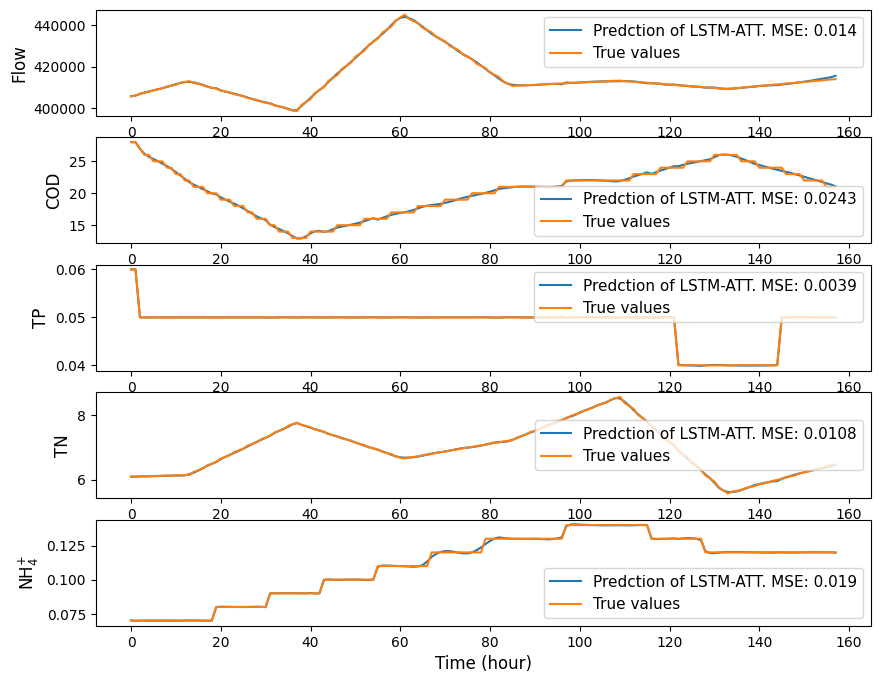

In [8]:
fig,ax=plt.subplots(5,1,figsize=(10,8))
ylbel = ['Flow','COD','TP','TN','NH'+'$_{4}^{+}$']
for i in range(5):
    mse = np.round(get_MSE(y[:,i],ytrain.detach().numpy()[:,i]),4)
    ax[i].plot(yre[:,i],label='Predction of LSTM-ATT. MSE: '+str(mse))
    ax[i].plot(ytrainre[:,i],label='True values')
    ax[i].set_ylabel(ylbel[i],fontsize=12)
    ax[i].set_xlabel('Time (hour)',fontsize=12)
    ax[i].legend(fontsize=11)
fig.savefig('prediction.png',dpi=200)